# Variance and PPP: Global Means


In [1]:
# Importing packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar

In [2]:
# minor helper method - returns the ppname for a particular driver
def pp(driver):
    if driver=='tos' or driver=='sos' or driver=='MLD_003':
        return 'ocean_month'
    elif driver=='intpp':
        return 'ocean_cobalt_omip_2d'
    elif driver=='chlos':
        return 'ocean_cobalt_omip_sfc'

In [3]:
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

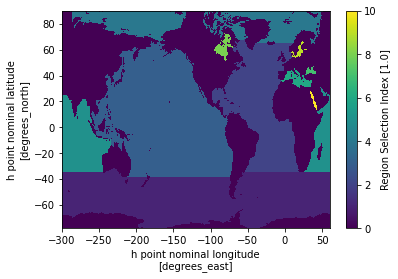

In [4]:
grid.basin.plot()
# use xarray where to grab stuff in particular basin
#where grid geolat > 0 --> gives north atlantic, ( can subset the basins more )

### Getting the time-series global mean from netcdf files for each driver and computing the monthly variances

In [5]:
tos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/tos_mean.nc')
sos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/sos_mean.nc')
mld_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/MLD_003_mean.nc')
npp_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/npp_mean.nc')


In [6]:
chlos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/chlos_mean.nc')


In [7]:
npp_month_var = (npp_mean['intpp'].groupby('time.month').std())**2

In [8]:
chlos_month_var = (chlos_mean['chlos'].groupby('time.month').std())**2

In [9]:
tos_month_var = (tos_mean['tos'].groupby('time.month').std())**2

In [10]:
sos_month_var = (sos_mean['sos'].groupby('time.month').std())**2

In [11]:
mld_month_var = (mld_mean['MLD_003'].groupby('time.month')).std()**2

### Methods to compute 1. the variance for a particular ensemble start year, and 2. average the variances over all ensemble start years

In [12]:
# returns the variance for a particular ensemble start year
def ens_var(start_year, driver_global, driver):
    # create a list of xarrays of control + ensemble data to be concatenated
    members = [*range(10)]
    ppname = pp(driver)
    
    # handle the control separately
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    members[0] = ctrl_slice
    
    # loop through all 9 ensemble members
    for member in range(1,10):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/'
                +folder+'/gfdl.ncrc4-intel18-prod-openmp/pp/'+ppname+'/ts/monthly/5yr/'+ppname+'.*'+driver+'.nc')
        ens_mem = xr.open_mfdataset(path)
        ens_mem = (ens_mem[driver].weighted(grid['areacello']).mean(['xh','yh'])).to_dataset()
        members[member] = ens_mem
        
    # combine all ensemble members and control into one xarray
    all_members = xr.concat(members,dim='members')
    
    # compute the variance
    variance = (all_members.std(dim='members')) ** 2
    
    return variance
    


In [13]:
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def avg_ens_var(driver_global, driver):
    # initialize total to be stddev of first ensemble - year '0123'
    
    ensembles = [*range(10)]
    first = ens_var(STARTS[0],driver_global,driver)
    timei = first.time
    ensembles[0] = first
    
    for ens in range(1,10):
        time_adjusted = ens_var(STARTS[ens],driver_global,driver).assign_coords(time=timei)
        ensembles[ens] = time_adjusted
    
    total = xr.concat(ensembles,dim='ensemble')
    avg = total.mean(dim='ensemble')
    
    return avg


### Running these methods on all of our driver variables:

In [14]:
tos_var = avg_ens_var(tos_mean,'tos')
with ProgressBar():
    tos_var = tos_var.compute()

[########################################] | 100% Completed | 55.7s


In [15]:
sos_var = avg_ens_var(sos_mean,'sos')
with ProgressBar():
    sos_var = sos_var.compute()
    
mld_var = avg_ens_var(mld_mean,'MLD_003')
with ProgressBar():
    mld_var = mld_var.compute()

[########################################] | 100% Completed | 58.9s
[########################################] | 100% Completed |  1min  1.5s


In [16]:
npp_var = avg_ens_var(npp_mean,'intpp')
with ProgressBar():
    npp_var = npp_var.compute()

[########################################] | 100% Completed | 50.7s


In [17]:
chlos_var = avg_ens_var(chlos_mean,'chlos')
with ProgressBar():
    chlos_var = chlos_var.compute()

[########################################] | 100% Completed | 51.2s


### Plotting the PPP for all our driver variables

In [58]:
def plot_ppp(driver_month_var, driver_var,driver):
    driver_var_array = driver_month_var.to_numpy()
    repeated = np.tile(driver_var_array, 10)
    
    driver_ens_array = driver_var.to_array().to_numpy()
    ratio = driver_ens_array / repeated
    ppp = np.ones(len(ratio)) - ratio
    plt.plot(ppp.squeeze())
    plt.title('PPP of '+driver)
    plt.xlabel('Time (Months after Initialization)')
    plt.ylabel('PPP')


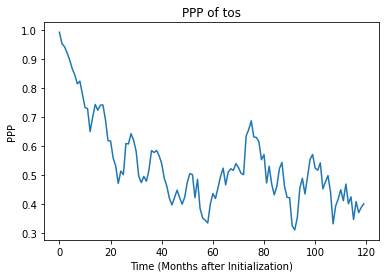

In [59]:
plot_ppp(tos_month_var,tos_var,'tos')

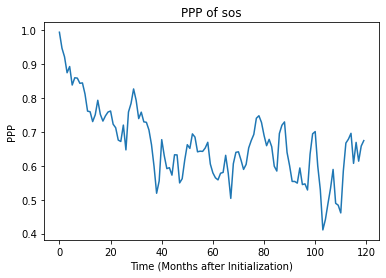

In [60]:
plot_ppp(sos_month_var,sos_var,'sos')

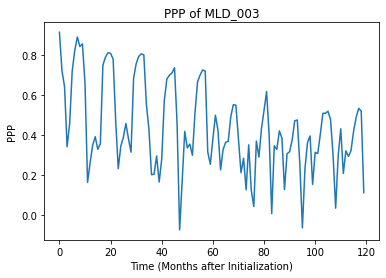

In [61]:
plot_ppp(mld_month_var,mld_var,'MLD_003')

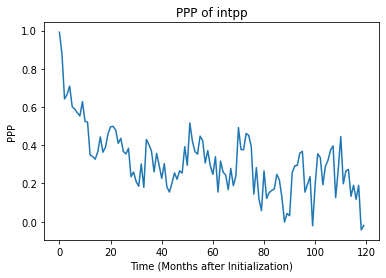

In [51]:
plot_ppp(npp_month_var,npp_var,'intpp')

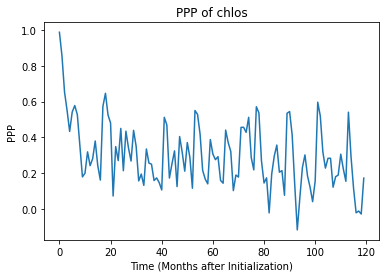

In [53]:
plot_ppp(chlos_month_var,chlos_var,'chlos')


# Packaged into one function:
Now, I'll put all of this together into one function that takes as input just the string driver and produces a plot of the PPP (will be useful later when adding more variables into the mix):

In [64]:
def driver_ppp_plot(driver):
    driver_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/'+driver+'_mean.nc')
    driver_month_var = (driver_mean[driver].groupby('time.month').std())**2
    
    driver_var = avg_ens_var(driver_mean,driver)
    with ProgressBar():
        driver_var = driver_var.compute()
    
    plot_ppp(driver_month_var,driver_var,driver)
#     driver_ppp = get_ppp(driver_var,driver_month_var)
    
#     # Plotting
#     plt.plot(driver_ppp, color='r',mfc='pink')
#     plt.title('PPP of ' + driver_name)
#     plt.xlabel('Time (Months after Initialization)')
#     plt.ylabel('PPP')

[########################################] | 100% Completed | 52.7s


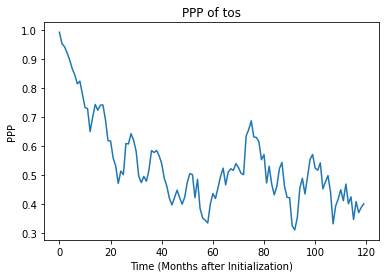

In [65]:
driver_ppp_plot('tos')

# Scratch Work

In [ ]:
driver_ppp_plot('sos', 'Sea Surface Salinity')

In [19]:
tos_ppp = get_ppp(tos_var,tos_month_var)
sos_ppp = get_ppp(sos_var,sos_month_var)
mld_ppp = get_ppp(mld_var,mld_month_var)
npp_ppp = get_ppp(npp_var,npp_month_var)
chlos_ppp = get_ppp(chlos_var,chlos_month_var)

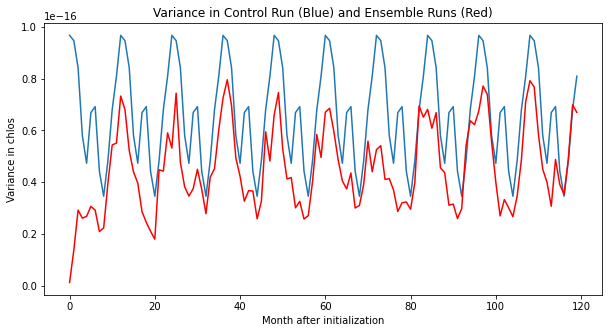

In [39]:
# sanity check method
def plot_both_variance(driver_month_var, driver_ens_var,driver):
    driver_var_array = driver_month_var.to_numpy()
    repeated = np.tile(driver_var_array, 10)
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(repeated)
    ax.plot(driver_ens_var[driver],color='r')
    plt.ylabel('Variance in ' + driver)
    plt.xlabel('Month after initialization')
    plt.title("Variance in Control Run (Blue) and Ensemble Runs (Red)")

plot_both_variance(chlos_month_var,chlos_var,'chlos')

In [18]:
def get_ppp(driver_ens_var, month_var):
    driver_ens_var = driver_ens_var.to_array()
    ppp = [*range(120)]
    for t in range(120):
        ppp[t] = 1 - (driver_ens_var.isel(time=t) / month_var['month'==t%12])
    return ppp
#check out .repeat() for numpy - consider repeating the control mean 

Text(0, 0.5, 'PPP')

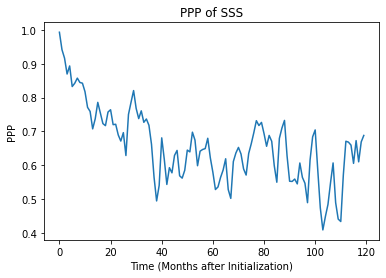

In [49]:
plt.plot(sos_ppp)
plt.title('PPP of SSS')
plt.xlabel('Time (Months after Initialization)')
plt.ylabel('PPP')
#plt.savefig('PPP of SST, Ensemble Start Year 208')

Text(0.5, 1.0, 'Variance in Control Run (Blue) and Ensemble Runs (Red)')

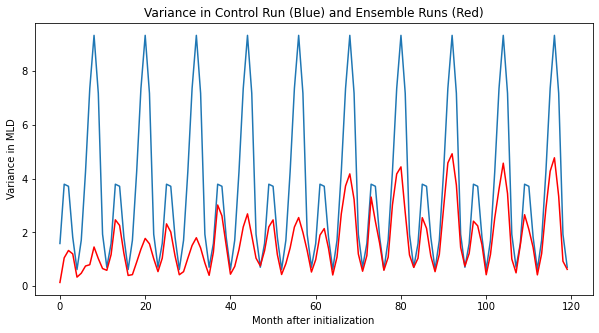

In [25]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(repeated)
ax.plot(mld_var['MLD_003'],color='r')
plt.ylabel('Variance in MLD')
plt.xlabel('Month after initialization')
plt.title("Variance in Control Run (Blue) and Ensemble Runs (Red)")

Text(0, 0.5, 'PPP')

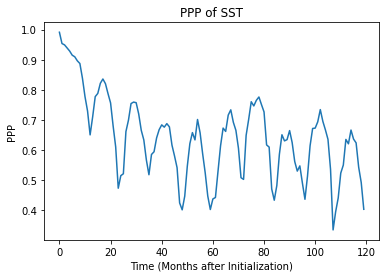

In [20]:
plt.plot(tos_ppp)
plt.title('PPP of SST')
plt.xlabel('Time (Months after Initialization)')
plt.ylabel('PPP')
#plt.savefig('PPP of SST, Ensemble Start Year 208')